Датасет Brain MRI segmentation был взят c Kaggle https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/drive/My\ Drive/mri-image-segmentation/lgg-mri-segmentation.zip

Загружаем аннотации из формата .csv

In [0]:
import pandas as pd
table0=pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')
table0.head(20)


Patient  RNASeqCluster  MethylationCluster  ...  race  ethnicity  death01
0   TCGA_CS_4941            2.0                 4.0  ...   3.0        2.0      1.0
1   TCGA_CS_4942            1.0                 5.0  ...   2.0        NaN      1.0
2   TCGA_CS_4943            1.0                 5.0  ...   3.0        NaN      0.0
3   TCGA_CS_4944            NaN                 5.0  ...   3.0        NaN      0.0
4   TCGA_CS_5393            4.0                 5.0  ...   3.0        NaN      0.0
5   TCGA_CS_5395            2.0                 4.0  ...   2.0        NaN      1.0
6   TCGA_CS_5396            3.0                 3.0  ...   3.0        2.0      0.0
7   TCGA_CS_5397            NaN                 4.0  ...   3.0        2.0      1.0
8   TCGA_CS_6186            2.0                 4.0  ...   3.0        2.0      1.0
9   TCGA_CS_6188            2.0                 4.0  ...   3.0        2.0      0.0
10  TCGA_CS_6290            1.0                 5.0  ...   NaN        NaN      0.0
11  TCGA_CS_6665            2.0                 5.0  ...   3.0        2.0      0.0
12  TCGA_CS_6666            NaN                 5.0  ...   3.0        2.0      0.0
13  TCGA_CS_6667            1.0                 3.0  ...   3.0        2.0      0.0
14  TCGA_CS_6668            3.0                 2.0  ...   3.0        2.0      0.0
15  TCGA_CS_6669            4.0                 1.0  ...   3.0        NaN      0.0
16  TCGA_DU_5849            4.0                 2.0  ...   3.0        2.0      0.0
17  TCGA_DU_5851            4.0                 5.0  ...   3.0        2.0      0.0
18  TCGA_DU_5852            2.0                 4.0  ...   3.0        2.0      1.0
19  TCGA_DU_5853            1.0                 5.0  ...   3.0        2.0      0.0

[20 rows x 18 columns]

In [0]:



import os
import cv2
from google.colab.patches import cv2_imshow
import json
import pandas as pd
from math import isnan
import numpy as np
from PIL import Image
from collections import OrderedDict
from pathlib import Path
import copy
from pycocotools import mask as cocomask



In [0]:
table0.shape

(110, 18)

Делаем COCO-format .json файл аннотаций:

У нас будет одна категория для сегментации tumor

In [0]:

info = {"year" : 2018,
        "version" : "1.0",
        "description" : "Ultrasound Nerve Segmentation",
        "contributor" : "Anna Shtangey",
        "url" : "annashtangey.pythonanywhere.com",
        "date_created" : "2020"
                    }
licenses = [{"id": 1,"name": "Attribution-NonCommercial", "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"}]
type = "instances"


masks = []
categories = [1]
names = []
bboxes=[]
areas=[]
annotations=[]
images = []
id =0
#Все картинки
img = sorted(list(Path("/content/lgg-mri-segmentation/kaggle_3m").rglob('*.tif')))

for im in img:
  
 
  
  
 

  #Пробуем извлечь данные из картинки:
  if len(str(im)) == 94 or len(str(im)) == 95 :
    
    msk = np.array(Image.open(im).convert('L'))


    contours, _ = cv2.findContours(msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    crowd = 0
    for contour in contours:
           
      if contour.size >= 6:
          crowd+=1 
          segmentation.append(contour.flatten().tolist())
    if crowd >1:
      iscrowd = 1
    else: 
      iscrowd = 0     
    try:
      RLEs = cocomask.frPyObjects(segmentation, msk.shape[0], msk.shape[1])
      RLE = cocomask.merge(RLEs)
 
      area = float(cocomask.area(RLE))
      
    except:
      area =[]
    [x, y, w, h] = cv2.boundingRect(msk)     
    bbox1 =[float(x), float(y), float(w), float(h)]
  
   
    areas.append(area)
    
    id += 1
    
    try:
      for s in range(len(segmentation[0])-1):
        segmentation[0][s]=float(segmentation[0][s])
    except:
      pass
  
    annotations.append({"segmentation" : segmentation,
                                  "area" : area,
                                  "iscrowd" : iscrowd,
                                  "image_id" : id,
                                  "bbox" : bbox1,
                                  "category_id" :  1,
                                  "id": id})
    images.append({"date_captured" : "2020",
                             "file_name" : str(im)[:-9]+".tif", 
                             "id" : id,
                             "license" : 1,
                             "url" : "",
                             "height" : msk.shape[0],
                             "width" : msk.shape[1]})


  else: 
    
    imag=np.array((Image.open(im).convert('RGB')))
  
  
     
 
    
  

CATEGORIESS = [
    {
        'id': 1,
        'name': 'tumor',
        'supercategory': 'shape',
    }
]

coco_output = {
        "info": info,
        "licenses": licenses ,
        "categories": CATEGORIESS,
        "images": [],
        "annotations": []
    }


for im_id in images:

    coco_output["images"].append(im_id)
    
for annotation_id in annotations:
        
    coco_output["annotations"].append(annotation_id)

with open('/content/annotation_train.json', 'w') as output_json_file:
  json.dump(coco_output, output_json_file)
  

In [0]:
#Скопировать файл аннотаций:
import shutil
shutil.copy ('/content/annotation_train.json', '/content/drive/My Drive/mri-image-segmentation/annotation_train.json')

'/content/drive/My Drive/mri-image-segmentation/annotation_train.json'

Устанавливаем все для запуска Detectron2:

In [0]:
pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-k5er0hw9
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-k5er0hw9
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275361 sha256=3d12f91cc32bfdc0dc0931d5a23e00014099ecf52d30cc295f6e369f37b5ad39
  Stored in directory: /tmp/pip-ephem-wheel-cache-4gzcw5qx/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


In [0]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1

import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [0]:
! pip install opencv-python
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3209 (delta 0), reused 1 (delta 0), pack-reused 3203
Receiving objects: 100% (3209/3209), 2.07 MiB | 1.54 MiB/s, done.
Resolving deltas: 100% (2197/2197), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 10.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200229-cp36-none-any.whl size=37811 sha256=e45e1c51708e1bea98ebe6e42ce635182932275ca59ca0a6ff6dca0ed138cd95
  Stored in directory: /root/.cache/pip/wheels/ac/1b/86/186592c75991ff5543a35f7372124556e916965377e7972ebd
Successfully built fvcore
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
import numpy as np
import os
import cv2
import random
from matplotlib import colors, pyplot as plt
%matplotlib inline
import json
from google.colab.patches import cv2_imshow
import detectron2

Запускаем Detectron2, сперва тестим на случайных изображениях

In [0]:
im= cv2.imread('/content/drive/My Drive/deepfashion2/dataset/image/000002.jpg')[:,:,::-1]


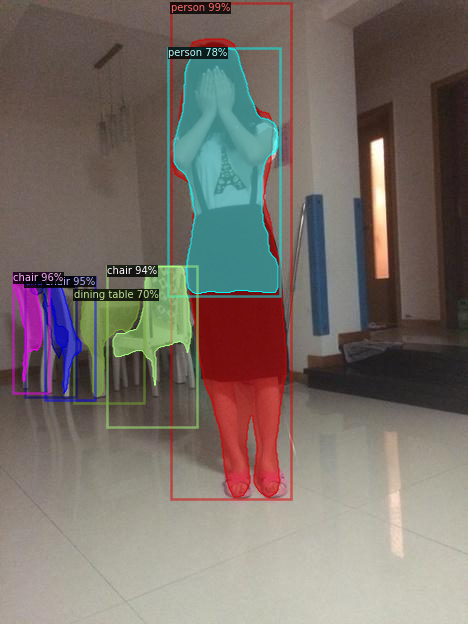

In [0]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")

cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Регистрируем новую базу данных:

In [0]:
import os
import numpy as np
import json


from detectron2.data.datasets import register_coco_instances
register_coco_instances("medical_train", {}, "/content/annotation_train.json", "/content/lgg-mri-segmentation/kaggle_3m")
register_coco_instances("medical_test", {}, "/content/annotation_train.json", "/content/lgg-mri-segmentation/kaggle_3m")


In [0]:
from detectron2.data import MetadataCatalog
medical_train_metadata = MetadataCatalog.get("medical_train")
medical_test_metadata = MetadataCatalog.get("medical_test")
medical_train_metadata

Metadata(evaluator_type='coco', image_root='/content/lgg-mri-segmentation/kaggle_3m', json_file='/content/annotation_train.json', name='medical_train', thing_classes=['tumor'], thing_dataset_id_to_contiguous_id={1: 0})

In [0]:
from detectron2.data import DatasetCatalog
medical_train_dict=DatasetCatalog.get("medical_train")
medical_test_dict=DatasetCatalog.get("medical_test")


[02/29 22:56:49 d2.data.datasets.coco]: Loaded 3929 images in COCO format from /content/annotation_train.json
[02/29 22:56:49 d2.data.datasets.coco]: Loaded 3929 images in COCO format from /content/annotation_train.json


Смотрим на загруженные данные:

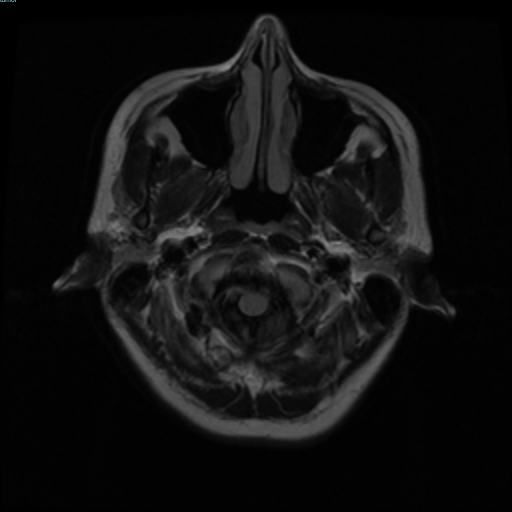

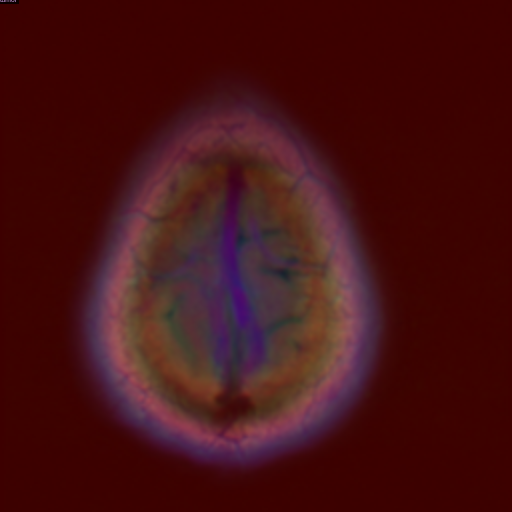

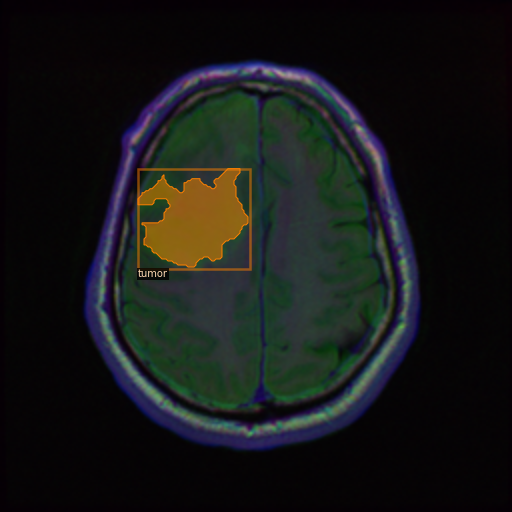

In [0]:
for d in random.sample(medical_train_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("medical_train"), scale=2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Подготавливаем систему к обучению:

In [84]:
from detectron2.engine import SimpleTrainer
from detectron2.config import get_cfg
from detectron2.modeling import build_model

from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader
    )
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("medical_train",)
cfg.DATASETS.TEST = ("medical_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.OUTPUT_DIR = "/content/output"
cfg.MODEL.DEVICE = "cuda"


cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"

cfg.SOLVER.WARMUP_ITERS = 3000
cfg.SOLVER.WARMUP_METHOD = "linear"






os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model= build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)
data_loader = build_detection_train_loader(cfg)

evaluator = detectron2.evaluation.COCOEvaluator("medical_test", cfg, distributed=True, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, "medical_test")

#DefaultTrainer.test(evaluators=evaluator)

[03/01 01:28:41 d2.data.datasets.coco]: Loaded 3929 images in COCO format from /content/annotation_train.json
[03/01 01:28:41 d2.data.build]: Removed 178 images with no usable annotations. 3751 images left.
[03/01 01:28:41 d2.data.common]: Serializing 3751 elements to byte tensors and concatenating them all ...
[03/01 01:28:41 d2.data.common]: Serialized dataset takes 3.15 MiB
[03/01 01:28:41 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/01 01:28:41 d2.data.build]: Using training sampler TrainingSampler
[03/01 01:28:41 d2.data.datasets.coco]: Loaded 3929 images in COCO format from /content/annotation_train.json
[03/01 01:28:41 d2.data.common]: Serializing 3929 elements to byte tensors and concatenating them all ...
[03/01 01:28:41 d2.data.common]: Serialized dataset takes 3.46 MiB


Обучаем нейросеть:

In [76]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/29 23:00:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[02/29 23:00:09 d2.engine.train_loop]: Starting training from iteration 0
[02/29 23:00:22 d2.utils.events]:  eta: 1:45:26  iter: 19  total_loss: 1.607  loss_cls: 0.731  loss_box_reg: 0.029  loss_mask: 0.691  loss_rpn_cls: 0.141  loss_rpn_loc: 0.004  time: 0.6350  data_time: 0.0145  lr: 0.000002  max_mem: 5088M
[02/29 23:00:34 d2.utils.events]:  eta: 1:45:03  iter: 39  total_loss: 1.161  loss_cls: 0.648  loss_box_reg: 0.017  loss_mask: 0.345  loss_rpn_cls: 0.108  loss_rpn_loc: 0.001  time: 0.6323  data_time: 0.0048  lr: 0.000003  max_mem: 5088M
[02/29 23:00:47 d2.utils.events]:  eta: 1:43:59  iter: 59  total_loss: 0.667  loss_cls: 0.521  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.089  loss_rpn_loc: 0.000  time: 0.6297  data_time: 0.0042  lr: 0.000005  max_mem: 5088M
[02/29 23:01:00 d2.utils.events]:  eta: 1:44:24  iter: 79  total_loss: 1.148  loss_cls: 0.388  loss_box_reg: 0.032  loss_mask: 0.685  loss_rpn_cls: 0.096  loss_rpn_loc: 0.002  time: 0.6332  data_time: 0.0040  lr:

In [82]:
%reload_ext tensorboard
%tensorboard --logdir '/content/output/'

Смотрим результаты:

In [0]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor


cfg.MODEL.WEIGHTS = os.path.join("/content/output", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55   # set the testing threshold for this model

predictor = DefaultPredictor(cfg)

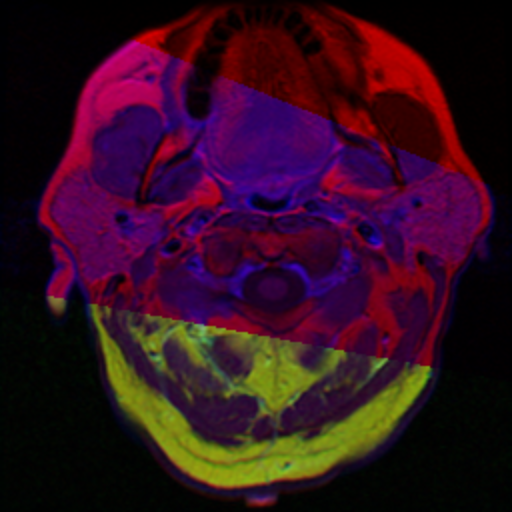

In [87]:
cfg = get_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
im= cv2.imread(os.path.join('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'))

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("medical_train"), scale=2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

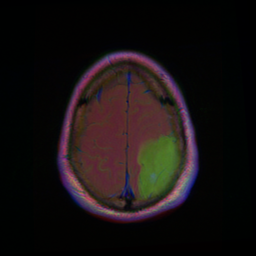

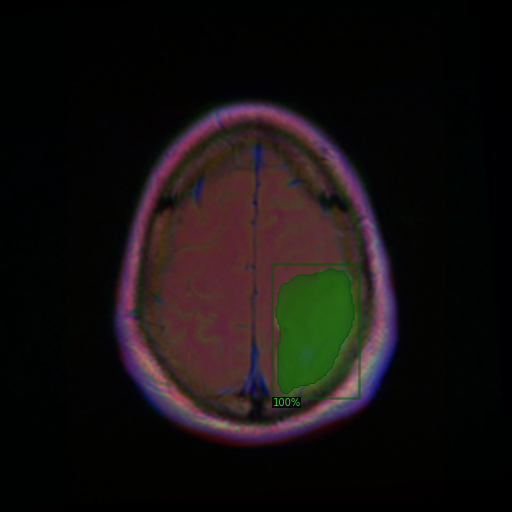

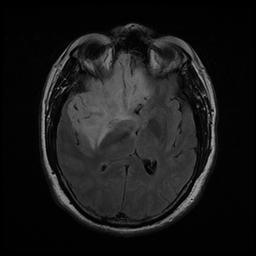

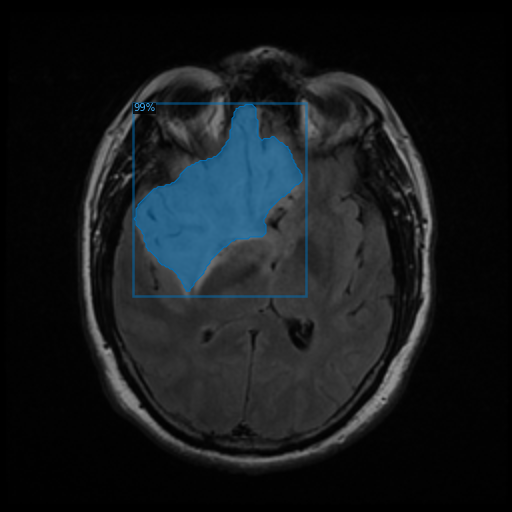

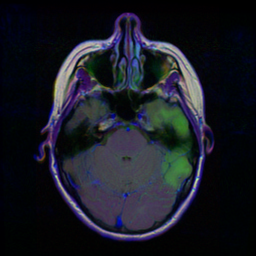

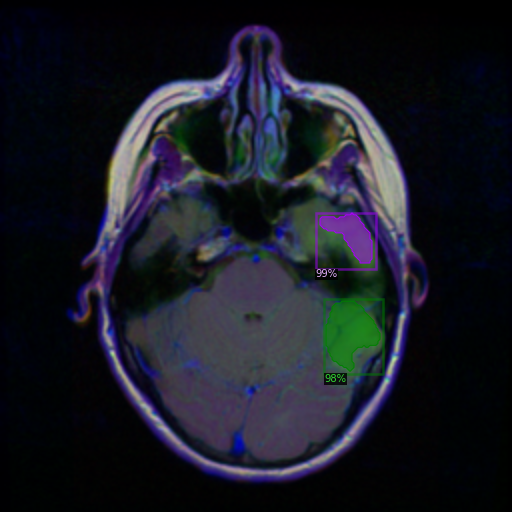

In [105]:
from detectron2.utils.visualizer import ColorMode


for d in random.sample(medical_train_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("medical_test"), scale=2)                 
    
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(im)
    cv2_imshow(v.get_image()[:, :, ::-1])

In [77]:
#Скопировать веса:
import shutil
shutil.copy ('/content/output/model_final.pth', '/content/drive/My Drive/mri-image-segmentation/model_final.pth')

'/content/drive/My Drive/mri-image-segmentation/model_final.pth'